<a href="https://colab.research.google.com/github/perpk/Huntington-DEG/blob/main/BNP_57_GE3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ανάλυση διαφορικής έκφρασης

Προαπαιτείται η ύπαρξη του αρχείου, το οποίο θα πρέπει να ανεβεί δια χειρός (μια αυτοματοποιημένη λύση μέσω Download από R και έπειτα ανάγνωση/άνοιγμα του αρχείου δεν λειτουργεί). Το αρχείο είναι διαθέσιμο [εδώ](https://ftp.ncbi.nlm.nih.gov/geo/series/GSE64nnn/GSE64810/suppl/GSE64810_mlhd_DESeq2_diffexp_DESeq2_outlier_trimmed_adjust.txt.gz) και περιέχει τα αποτελέσματα της ανάλυσης διαφορικής έκφρασης μέσω DESeq2.

In [34]:
expressions <- read.table("GSE64810_mlhd_DESeq2_diffexp_DESeq2_outlier_trimmed_adjust.txt.gz", header=TRUE, sep = "\t", comment.char = "!")

Ισχύει το ίδιο και για το αρχείο που περιέχει τα κανονικοποιημένα δεδομένα ανά δείγμα όπως παραπάνω. Το αρχείο αυτό είναι διαθέσιμο [εδώ](https://www.ncbi.nlm.nih.gov/geo/download/?type=rnaseq_counts&acc=GSE64810&format=file&file=GSE64810_norm_counts_FPKM_GRCh38.p13_NCBI.tsv.gz)

In [35]:
counts <- read.table("GSE64810_norm_counts_FPKM_GRCh38.p13_NCBI.tsv", header=TRUE, sep="\t")

Ορισμός padj και Log2FC για επιλογή στατιστικά σημαντικών εκφράσεων με ποσοστό έκφρασης +/-50%.

In [36]:
padj_threshold <- 0.01
log2FoldChange_threshold = 1
expressions$level <- "Not DE"
expressions$level[expressions$log2FoldChange >= log2FoldChange_threshold & expressions$padj < padj_threshold] <- "Over"
expressions$level[expressions$log2FoldChange <= -log2FoldChange_threshold & expressions$padj < padj_threshold] <- "Under"

overexpressed <- expressions[expressions$level == "Over",]
underexpressed <- expressions[expressions$level == "Under",]

# order sets of over- and underexpressed genes in a descending fashion
overexpressed <- overexpressed[order(-overexpressed$log2FoldChange),]
underexpressed <- underexpressed[order(underexpressed$log2FoldChange),]



Επιλογή των 5 υπέρ- και 5- υπό-εκφραζόμενων γονιδίων με αντίστοιχα υψηλότερες τίμες εντός των συνόλων.

In [37]:
selection <- 5
top_over <- head(overexpressed, selection)
top_under <- head(underexpressed, selection)
top_degs <- rbind(top_over, top_under)

Plot διαγράμματος σκέδασης (Volcano) διαφορικά εκφραζόμενων γονιδίων.

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



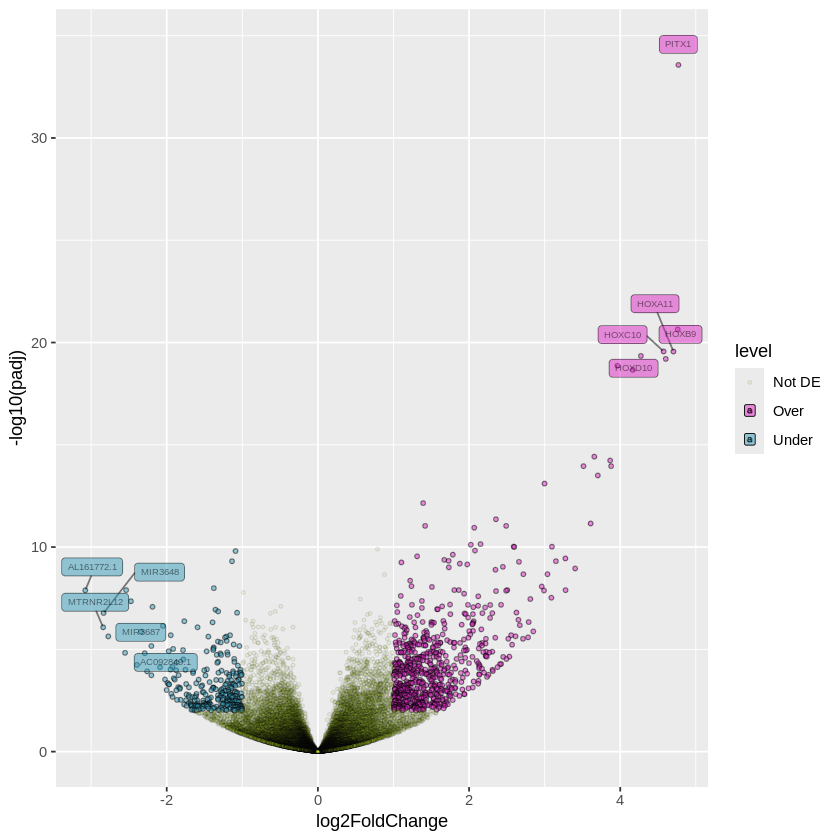

In [41]:
install.packages("ggrepel")
library(ggplot2)
library(ggrepel)
colours <- c("Over" = "#de28c3", "Not DE" = "#b7de28", "Under" = "#369bba")
sizes <- c("Over" = 1, "Not DE" = 0.7, "Under" = 1)
alphas <- c("Over" = 0.5, "Not DE" = 0.1, "Under" = 0.5)
ggplot(data=data.frame(expressions), aes(x=log2FoldChange, y=-log10(padj), fill=level, size=level, alpha=level, label=symbol)) +
  geom_point(shape=21,colour="black") +
  scale_fill_manual(values=colours) +
  scale_size_manual(values=sizes) +
  scale_alpha_manual(values=alphas) +
  geom_label_repel(data = top_degs, aes(label = symbol), force = 2, nudge_y = 1, size = 2)


Εξαγωγή αποτελεσμάτων

# Ανάλυση WGCNA

Φόρτωση αναγκαίων βιβλιοθηκών

In [ ]:
if (!require("BiocManager", quietly= TRUE))
  install.packages("BiocManager")

BiocManager::install("biomaRt")
install.packages("dplyr")
library(dplyr)
library(biomaRt)


Φιλτράρισμα του συνόλου τιμών έκφρασης γονιδίων ανά δείγμα με βάση του συνόλου δεδομένων διαφορικής έκφρασης με padj <= 0,05 όπως και μετάφραση των Entrezgene IDs σε σύμβολα γονιδίων μέσω υπηρεσίας HUGO

In [50]:
mart <- useMart("ENSEMBL_MART_ENSEMBL");
mart <- useDataset('hsapiens_gene_ensembl', mart)
hgnc <- getBM(mart = mart, values = expressions[expressions$padj <= 0.05,]$symbol, attributes=c("entrezgene_id"), filter="external_gene_name")

c <- dplyr::filter(counts, GeneID %in% hgnc$entrezgene_id)
temp <- c[,-1];
rownames(temp) <- c$GeneID;
c <- as.data.frame(temp);

Υπολογισμός soft Threshold και επιλογή τιμής power για παρακάτω υπολογισμό πίνακα γειτνίασης. Η τιμή που θα επιλεχθεί θα πρέπει ιδανικά να ειναι η μικρότερη του συνόλου άνω του 0,8 του Scale Free Topology model fit

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.19 (BiocManager 1.30.25), R 4.4.1 (2024-06-14)

Installing package(s) 'WGCNA'

also installing the dependencies ‘impute’, ‘preprocessCore’, ‘GO.db’


Old packages: 'rstudioapi'

Loading required package: dynamicTreeCut

Loading required package: fastcluster


Attaching package: ‘fastcluster’


The following object is masked from ‘package:stats’:

    hclust





Attaching package: ‘WGCNA’


The following object is masked from ‘package:stats’:

    cor




pickSoftThreshold: will use block size 4023.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 4023 of 4023


Warning message:
“executing %dopar% sequentially: no parallel backend registered”


   Power SFT.R.sq  slope truncated.R.sq mean.k. median.k. max.k.
1      1  0.15300  1.140          0.824 1180.00  1200.000 1900.0
2      2  0.00833 -0.162          0.860  492.00   490.000 1050.0
3      3  0.20600 -0.812          0.895  245.00   238.000  631.0
4      4  0.35400 -1.070          0.930  137.00   129.000  403.0
5      5  0.45300 -1.230          0.943   83.30    77.600  270.0
6      6  0.52800 -1.280          0.954   54.00    49.500  187.0
7      7  0.57700 -1.260          0.955   36.80    32.700  133.0
8      8  0.61200 -1.220          0.944   26.10    22.200   97.4
9      9  0.68700 -1.160          0.952   19.10    15.300   74.0
10    10  0.76600 -1.150          0.972   14.40    10.800   59.5
11    11  0.82300 -1.240          0.986   11.10     7.740   51.1
12    12  0.84400 -1.390          0.993    8.70     5.640   46.9
13    13  0.86800 -1.500          0.987    6.95     4.170   43.5
14    14  0.89000 -1.600          0.990    5.65     3.130   40.9
15    15  0.90300 -1.630 

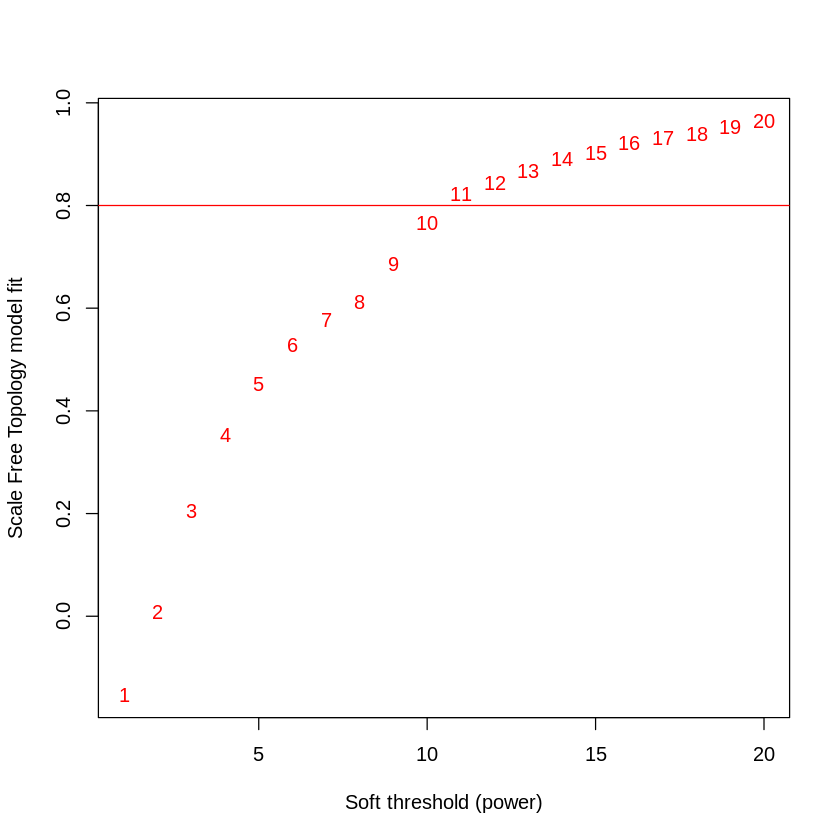

In [55]:
BiocManager::install("WGCNA")
library(WGCNA)

powers = c(1:20)
sft = pickSoftThreshold(t(c), powerVector=powers, verbose=5)
plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2], type="n", xlab="Soft threshold (power)", ylab="Scale Free Topology model fit")
text(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2], labels=powers, col="red")
abline(h=0.8, col="red")

Αντίστοιχα με την τιμή που προκύπτει απο το προηγούμενο βήμα, υπολογισμός του πίνακα γειτνίασης (η τιμή μετά την τελευταία εκτέλεση ήταν 11 και πρέπει ενδεχομένως να προσαρμοστεί σε νέα εκτέλεση.

In [58]:
install.packages("janitor")
library(conflicted)

softPower = 11
conflicts_prefer(WGCNA::cor)
adjacency = adjacency(t(c), power = softPower)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

[conflicted] Removing existing preference.
[conflicted] Will prefer WGCNA::cor over any other package.


Υπολογισμός πίνακα ομοιότητας

In [59]:
TOM = TOMsimilarity(adjacency)
dissTOM = 1 - TOM

..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


Εκτέλεση ιεραρχικής ομαδοποίησης και οπτικοποίηση σε δενδρόγραμμα.

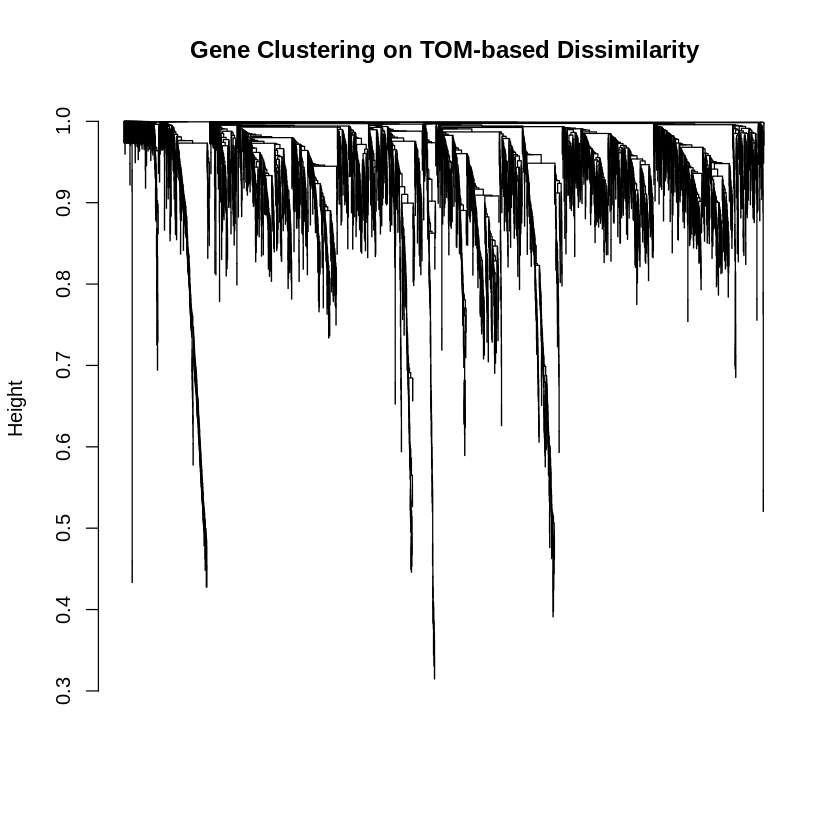

In [66]:
geneTree = hclust(as.dist(dissTOM), method = "average")
plot(geneTree, xlab="", sub="", main="Gene Clustering on TOM-based Dissimilarity", labels=FALSE, hang=0.04)

"Κόψιμο" δένδρου και οπτικοποίηση της ομαδοποίησης.

 ..cutHeight not given, setting it to 0.997  ===>  99% of the (truncated) height range in dendro.
 ..done.


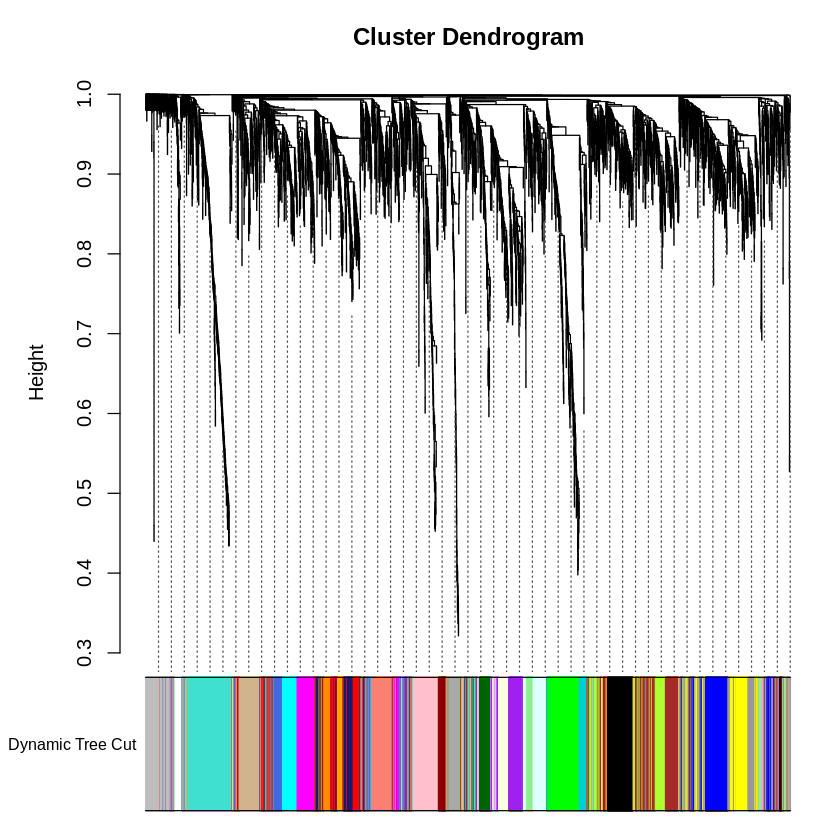

In [67]:
dynamicMods = cutreeDynamic(dendro = geneTree, distM = dissTOM, deepSplit = 2, pamRespectsDendro = FALSE, minClusterSize = 30)
dynamicColors = labels2colors(dynamicMods)
plotDendroAndColors(geneTree, dynamicColors, "Dynamic Tree Cut", dendroLabels = FALSE, hang = 0.03, addGuide = TRUE, guideHang = 0.05)

Ανεύρεση κομβικών γονιδίων εντός των ομάδων

In [76]:
library(stringr)

MEList = moduleEigengenes(t(c), colors = dynamicColors)
MEs = MEList$eigengenes

moduleMembership = cor(t(c), MEs, use = "pairwise.complete.obs")

hubGenes <- c()
for (group in colnames(moduleMembership)) {
  modGenes = (moduleColors == group %>% str_replace("ME",""))
  hubGene = names(which.max(moduleMembership[modGenes, group]))
  cat("Hub gene for module", group, ":", hubGene, "\n")
  hubGenes <- c(hubGenes, hubGene)
}
hubGenes <- unique(hubGenes)


Hub gene for module MEblack : 8773 
Hub gene for module MEblue : 10285 
Hub gene for module MEbrown : 55970 
Hub gene for module MEcyan : 6855 
Hub gene for module MEdarkgreen : 10894 
Hub gene for module MEdarkgrey : 219681 
Hub gene for module MEdarkorange : 529 
Hub gene for module MEdarkred : 4185 
Hub gene for module MEdarkturquoise : 4237 
Hub gene for module MEgreen : 2331 
Hub gene for module MEgreenyellow : 4853 
Hub gene for module MEgrey : 64968 
Hub gene for module MEgrey60 : 196528 
Hub gene for module MElightcyan : 7132 
Hub gene for module MElightgreen : 7408 
Hub gene for module MElightyellow : 3122 
Hub gene for module MEmagenta : 8506 
Hub gene for module MEmidnightblue : 80762 
Hub gene for module MEorange : 9737 
Hub gene for module MEpink : 392862 
Hub gene for module MEpurple : 7805 
Hub gene for module MEred : 55530 
Hub gene for module MEroyalblue : 25789 
Hub gene for module MEsalmon : 10452 
Hub gene for module MEtan : 79813 
Hub gene for module MEturquoise : 

Μετάφραση Entrez IDs γονιδίων σε σύμβολα μέσω υπηρεσίας HUGO

In [77]:
hgnc_genes_in_model <- getBM(attributes = c("hgnc_symbol"), filters="entrezgene_id", mart=mart, values=rownames(moduleMembership))
hgnc_genes_in_model

hgnc_symbol
<chr>
CDH2
NAALADL1
SIGLEC14
ZBTB33
TANK
HOTAIR
SRRM2-AS1
ZBTB42
ZNF37BP
